# TFM Aplicación de algoritmos escalables para el análisis y extracción de textos y búsqueda de patrones en el ámbito hospitalario
## eBurnout Text analysis in the real dataset
## @autor: Jesús García García

## Carga de Datos

In [562]:
#Imports de Google Cloud Storage y librerías para el tratamiento de los datos
import google.datalab.storage as storage
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from io import BytesIO
%matplotlib inline

#Indicamos el nombre del Bucket de Google Cloud Storage en donde se encuentra el Dataset previamente procesado por DataPrep
mybucket = storage.Bucket('my-first-project-7d187')

#Indicamos el nombre del fichero CSV a tratar
data_csv = mybucket.object('eBurnout_DatasetReal31082018.csv')

#Lectura del fichero CSV
uri = data_csv.uri
%gcs read --object $uri --variable data

#Transformación de Dataset en columnas delimitadas por ;
df = pd.read_csv(BytesIO(data),delimiter=';',error_bad_lines=False,parse_dates=['Fecha toma'])

#Leemos las cinco primeras filas del Dataset (cabecera)
df.head()

,email,usuario,hospital,edad,especialidad,estado civil,sexo,tipo contrato,tipo trabajo,tiempo vida laboral,...,heart_max (1),heart_min(1),heart_max (2),heart_min(2),heart_max (3),heart_min(3),Fecha toma,Temperatura max min,Media historica temperatura,burnout
0,uemusuario2@gmail.com,1,Son Llatzer,30-34,Anestesiologia y Reanimacion,soltero,hombre,adjunto,hospitalario,1.0,...,123.0,88.0,150.0,123.0,220.0,150.0,2018-07-17,32/19,31/18,NO
1,uemusuario1@gmail.com,2,Son Llatzer,20-24,Analisis Clinicos,casado,hombre,residente,ambulatorio,2.0,...,128.0,86.0,146.0,120.0,228.0,146.0,2018-06-08,25/13,26/14,SÍ
2,uemusuario11@gmail.com,3,Infanta Sofia,50-54,Angiologia y Cirugia Vascular,casado,mujer,residente,hospitalario,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2018-06-18,32/17,28/14,NO
3,uemusuario5@gmail.com,4,Infanta Sofia,30-34,Anatomia Patologica,soltero,hombre,residente,urgencias,28.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2018-05-30,21/12,25/12,NO
4,uemusuario14@gmail.com,5,Infanta Sofia,35-39,Psiquiatria,casado,mujer,adjunto,hospitalario,10.0,...,128.0,92.0,156.0,128.0,220.0,156.0,2018-05-30,21/12,25/12,SÍ


## Análisis y exploración del Dato

In [563]:
#Exploración de los tipos de datos del fichero
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 38 columns):
email                          168 non-null object
usuario                        168 non-null int64
hospital                       166 non-null object
edad                           165 non-null object
especialidad                   165 non-null object
estado civil                   165 non-null object
sexo                           165 non-null object
tipo contrato                  165 non-null object
tipo trabajo                   165 non-null object
tiempo vida laboral            165 non-null float64
tiempo plaza actual            165 non-null float64
altura                         165 non-null float64
peso                           165 non-null float64
ejercicio                      165 non-null object
consent                        167 non-null float64
free text survey               167 non-null object
ae                             144 non-null float64
d                      

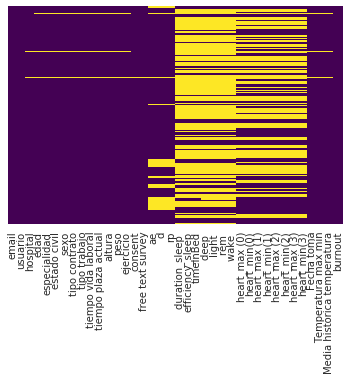

In [564]:
# Comprobamos los datos faltantes
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

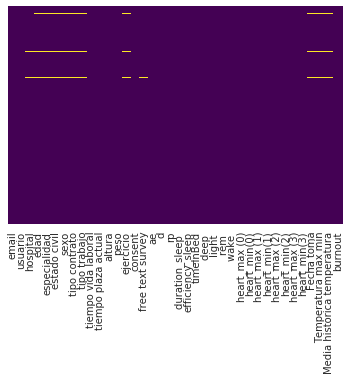

In [565]:
# Sustituimos los datos faltantes o nulos por el valor media
df = df.fillna(df.mean())
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

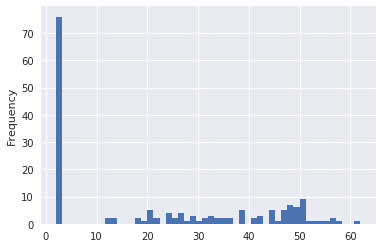

In [566]:
#Visualización de la longitud de las opiniones vertidas (y= frecuencia, x=total de opiniones) El 0 significa que hay muchos usuarios que no han opinado
df.dropna(subset=['free text survey'], inplace=True)  #Quitamos nulos para poder sacar la longitud del texto. Si no los quitamos el sistema detectará que los valores nulos float no tienen longitud
df['length'] = df['free text survey'].apply(len)
df['length'].plot(bins=50, kind='hist') 

In [567]:
#Descripción de la longitud de los mensajes (La longitud total aparece en el max)
df.length.describe()

count    167.000000
mean      21.586826
std       20.201171
min        2.000000
25%        2.000000
50%       20.000000
75%       42.000000
max       62.000000
Name: length, dtype: float64

In [568]:
#Vamos a crear un nuevo df con las columnas de email y free text survey
dftext= df[['email','hospital','free text survey','length','burnout']].copy()

In [569]:
dftext.head()

,email,hospital,free text survey,length,burnout
0,uemusuario2@gmail.com,Son Llatzer,"""""",2,NO
1,uemusuario1@gmail.com,Son Llatzer,Mejor sueldo,12,SÍ
2,uemusuario11@gmail.com,Infanta Sofia,"""""",2,NO
3,uemusuario5@gmail.com,Infanta Sofia,Cambiar de trabajo,18,NO
4,uemusuario14@gmail.com,Infanta Sofia,Tendrian que contratar mas personal,35,SÍ


In [570]:
#Borramos caracteres extraños del nuevo Dataset (Algunos de ellos no se eliminarán porque son útiles para la personalidad)
dftext['free text survey'] = df['free text survey'].str.replace(r"[/%_*\"\'@$,]", '')
#Normalizamos las longitudes correctas después de realizar la limpieza
dftext['length'] = dftext['length'].replace([2],[0])

In [571]:
#Comprobamos que la limpieza se ha realizado correctamente
dftext.head()

,email,hospital,free text survey,length,burnout
0,uemusuario2@gmail.com,Son Llatzer,,0,NO
1,uemusuario1@gmail.com,Son Llatzer,Mejor sueldo,12,SÍ
2,uemusuario11@gmail.com,Infanta Sofia,,0,NO
3,uemusuario5@gmail.com,Infanta Sofia,Cambiar de trabajo,18,NO
4,uemusuario14@gmail.com,Infanta Sofia,Tendrian que contratar mas personal,35,SÍ


In [572]:
#Conteo de palabras


# Función para calcular la varianza
def var_row(row):
  l = []
  #Each entry separated by " " (espacio)
  for i in row.split(' '):
     l.append(len(i.split()))
  return np.var(l)


# Número de palabras por cada comentario
dftext['words_comment_token'] = dftext['free text survey'].astype(str).str.split()
dftext['words_comment'] = dftext['free text survey'].str.count(' ') + 1
dftext['words_comment'] = dftext['words_comment'].replace([1.0],[0.0])
# Varianza en el conteo de las palabras
dftext['variance_word_counts'] = dftext['free text survey'].apply(lambda x: var_row(x))


#Conteo de símbolos que pueden determinar la personalidad

#dftext['puntos_suspensivos'] = dftext['free text survey'].apply(lambda x: x.count('1'))

#Imprimimos info del Dataset
dftext.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167 entries, 0 to 167
Data columns (total 8 columns):
email                   167 non-null object
hospital                166 non-null object
free text survey        167 non-null object
length                  167 non-null int64
burnout                 167 non-null object
words_comment_token     167 non-null object
words_comment           167 non-null float64
variance_word_counts    167 non-null float64
dtypes: float64(2), int64(1), object(5)
memory usage: 11.7+ KB


In [573]:
dftext.head()

,email,hospital,free text survey,length,burnout,words_comment_token,words_comment,variance_word_counts
0,uemusuario2@gmail.com,Son Llatzer,,0,NO,[],0.0,0.0
1,uemusuario1@gmail.com,Son Llatzer,Mejor sueldo,12,SÍ,"[Mejor, sueldo]",2.0,0.0
2,uemusuario11@gmail.com,Infanta Sofia,,0,NO,[],0.0,0.0
3,uemusuario5@gmail.com,Infanta Sofia,Cambiar de trabajo,18,NO,"[Cambiar, de, trabajo]",3.0,0.0
4,uemusuario14@gmail.com,Infanta Sofia,Tendrian que contratar mas personal,35,SÍ,"[Tendrian, que, contratar, mas, personal]",5.0,0.0


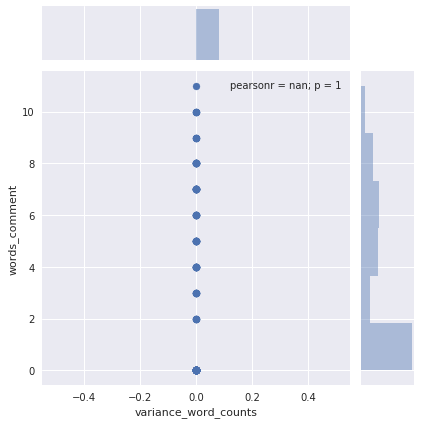

In [574]:
sns.jointplot(x='variance_word_counts',y='words_comment',data=dftext)

In [575]:
#Ver usuarios que han participado más en el experimento (no se tiene en cuanta que hayan dejado un comentario o no)
groupedall = dftext.groupby('email').agg({'email':'count'})
groupedall.sort_values('email', ascending=False)

,email
email,
uemusuario15@gmail.com,20
uemusuario5@gmail.com,16
uemusuario13@gmail.com,12
uemusuario1@gmail.com,10
uemusuario8@gmail.com,9
uemusuario7@gmail.com,9
uemusuario12@gmail.com,9
hs12@g.com,8
hs56@g.com,7


In [576]:
#Ver usuarios que han participado más en el experimento (que han dejado comentarios)
dfparticipaciontext = dftext.copy()
dfparticipaciontext.drop(dfparticipaciontext[dfparticipaciontext.words_comment == 0.0].index, inplace=True)
groupedcomment = dfparticipaciontext.groupby('email').agg({'email':'count'})
groupedcomment.sort_values('email', ascending=False)

,email
email,
uemusuario5@gmail.com,16
uemusuario13@gmail.com,10
uemusuario12@gmail.com,6
hs8@g.com,4
uemusuario8@gmail.com,4
uemusuario15@gmail.com,4
hs10@g.com,4
uemusuario9@gmail.com,3
hs13@g.com,3


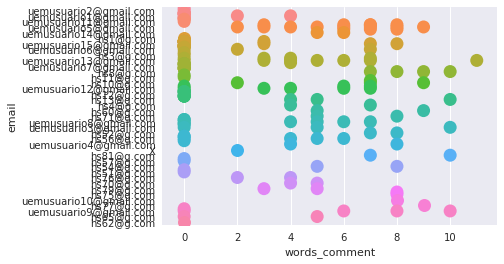

In [577]:
#Imprimir SwarmPlot de la cantidad de palabras según email
sns.swarmplot(x="words_comment", y="email", data=dftext,size=13, linewidth=0)

In [578]:
#Creamos y dividimos los dos Dataframes en usuarios con y sin pulsera
dftextnopulsera= dftext.copy()
dftextpulsera= dftext.copy()
#Normalizamos los datos (Sin pulsera)
dftextnopulsera = dftextnopulsera[~dftextnopulsera['email'].isin(['uemusuario1@gmail.com','uemusuario2@gmail.com','uemusuario3@gmail.com','uemusuario4@gmail.com','uemusuario5@gmail.com','uemusuario6@gmail.com','uemusuario7@gmail.com','uemusuario8@gmail.com','uemusuario9@gmail.com','uemusuario10@gmail.com','uemusuario11@gmail.com','uemusuario12@gmail.com','uemusuario13@gmail.com','uemusuario14@gmail.com','uemusuario15@gmail.com'])]
#Normalizamos los datos (Con pulsera)
dftextpulsera = dftextpulsera[dftextpulsera['email'].isin(['uemusuario1@gmail.com','uemusuario2@gmail.com','uemusuario3@gmail.com','uemusuario4@gmail.com','uemusuario5@gmail.com','uemusuario6@gmail.com','uemusuario7@gmail.com','uemusuario8@gmail.com','uemusuario9@gmail.com','uemusuario10@gmail.com','uemusuario11@gmail.com','uemusuario12@gmail.com','uemusuario13@gmail.com','uemusuario14@gmail.com','uemusuario15@gmail.com'])]


In [579]:
dftextnopulsera.head()

,email,hospital,free text survey,length,burnout,words_comment_token,words_comment,variance_word_counts
5,hs1@g.com,Infanta Sofia,,0,NO,[],0.0,0.0
8,hs3@g.com,Infanta Sofia,,0,NO,[],0.0,0.0
11,hs8@g.com,Infanta Sofia,Sentirme tenido mas en cuenta en la toma de de...,54,NO,"[Sentirme, tenido, mas, en, cuenta, en, la, to...",10.0,0.0
12,hs11@g.com,Infanta Sofia,,0,NO,[],0.0,0.0
13,hs10@g.com,Infanta Sofia,Reducir sobrecargas de trabajo (mas medicos ma…,48,SÍ,"[Reducir, sobrecargas, de, trabajo, (mas, medi...",7.0,0.0


In [580]:
dftextpulsera.head()

,email,hospital,free text survey,length,burnout,words_comment_token,words_comment,variance_word_counts
0,uemusuario2@gmail.com,Son Llatzer,,0,NO,[],0.0,0.0
1,uemusuario1@gmail.com,Son Llatzer,Mejor sueldo,12,SÍ,"[Mejor, sueldo]",2.0,0.0
2,uemusuario11@gmail.com,Infanta Sofia,,0,NO,[],0.0,0.0
3,uemusuario5@gmail.com,Infanta Sofia,Cambiar de trabajo,18,NO,"[Cambiar, de, trabajo]",3.0,0.0
4,uemusuario14@gmail.com,Infanta Sofia,Tendrian que contratar mas personal,35,SÍ,"[Tendrian, que, contratar, mas, personal]",5.0,0.0


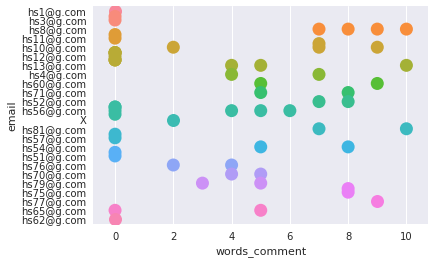

In [581]:
#Imprimir SwarmPlot de la cantidad de palabras según email (NO PULSERA)
sns.swarmplot(x="words_comment", y="email", data=dftextnopulsera,size=13, linewidth=0)

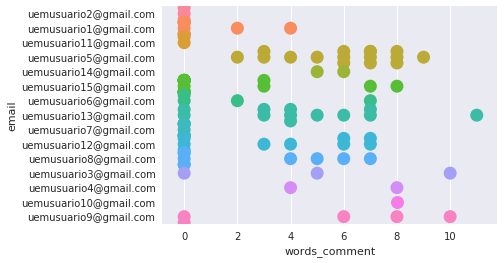

In [582]:
#Imprimir SwarmPlot de la cantidad de palabras según email (SÍ PULSERA)
sns.swarmplot(x="words_comment", y="email", data=dftextpulsera,size=13, linewidth=0)

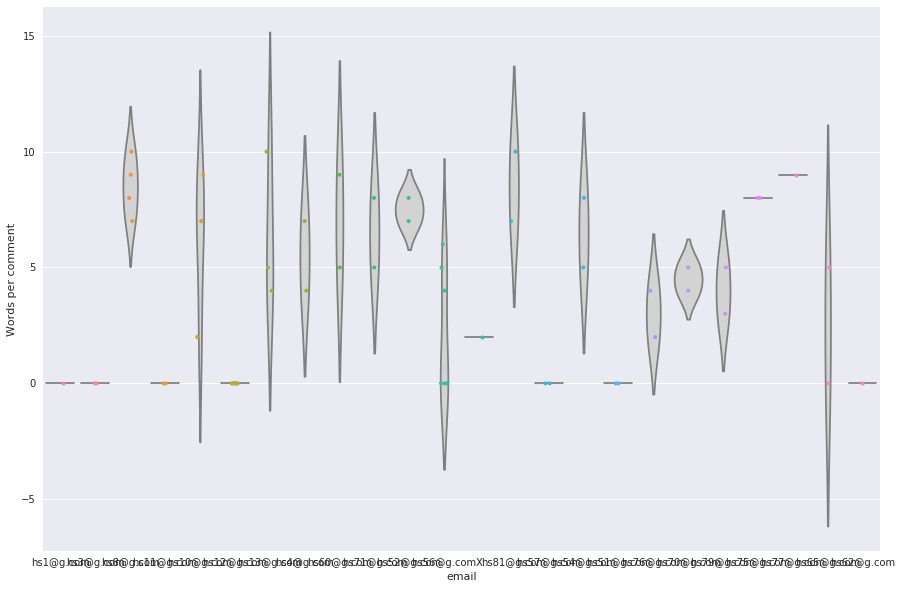

In [583]:
# Imprimir Plot cantidad de palabras vs email (NO PULSERA)
plt.figure(figsize=(15,10))
sns.violinplot(x='email', y='words_comment', data=dftextnopulsera, inner=None, color='lightgray')
sns.stripplot(x='email', y='words_comment', data=dftextnopulsera, size=4, jitter=True)
plt.ylabel('Words per comment')
plt.show()

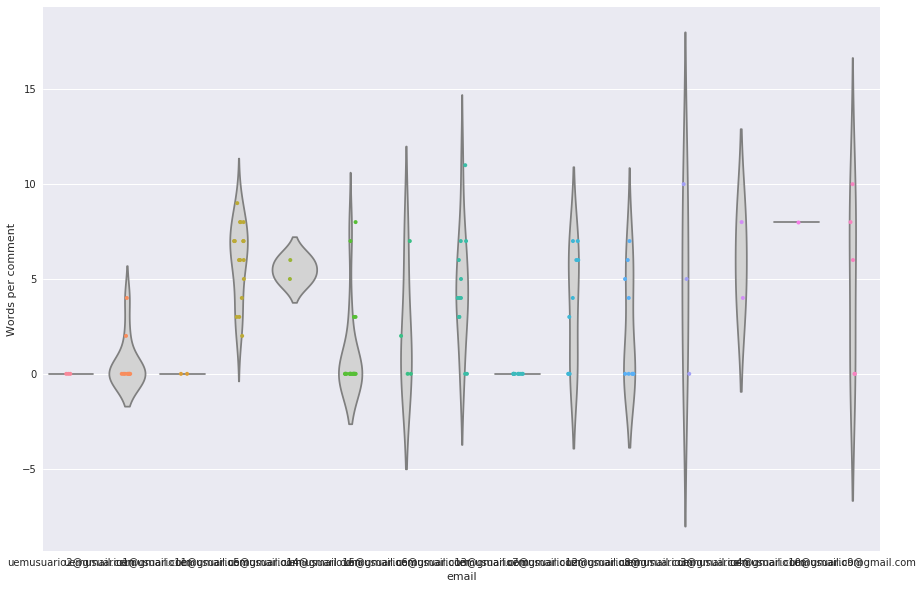

In [584]:
# Imprimir Plot cantidad de palabras vs email (SÍ PULSERA)
plt.figure(figsize=(15,10))
sns.violinplot(x='email', y='words_comment', data=dftextpulsera, inner=None, color='lightgray')
sns.stripplot(x='email', y='words_comment', data=dftextpulsera, size=4, jitter=True)
plt.ylabel('Words per comment')
plt.show()

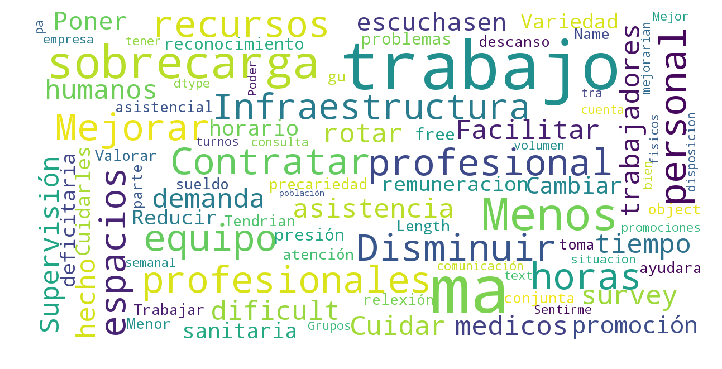

In [585]:
#Nube de palabras de todas las opiniones de todos los usuarios
from stop_words import get_stop_words
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
#stop_words = get_stop_words('es')
stopwords = get_stop_words('spanish') #https://pypi.org/project/stop-words/

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(dftext['free text survey'])

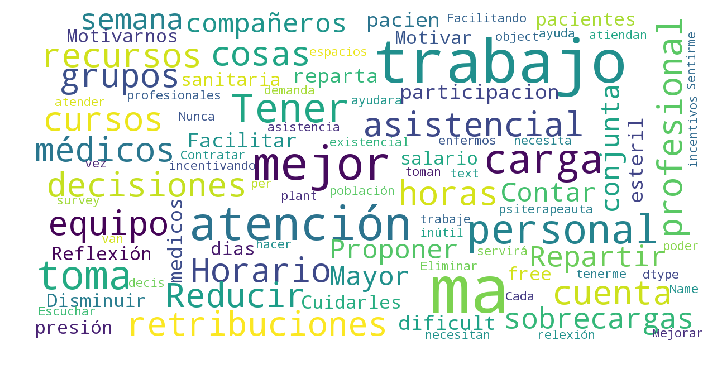

In [586]:
#Nube de palabras de todas las opiniones de los usuarios sin pulsera
from stop_words import get_stop_words
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
#stop_words = get_stop_words('es')
stopwords = get_stop_words('spanish') #https://pypi.org/project/stop-words/

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(dftextnopulsera['free text survey'])

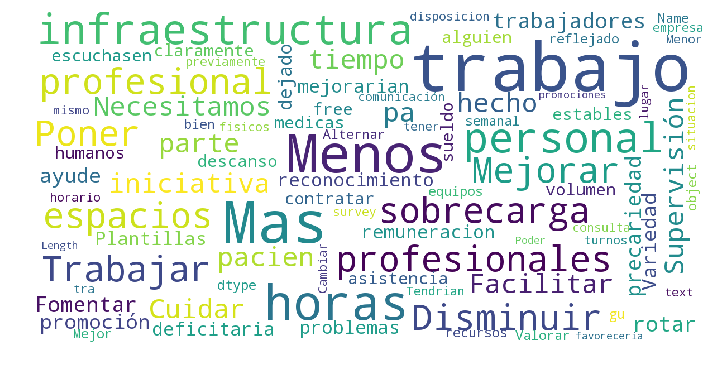

In [587]:
#Nube de palabras de todas las opiniones de los usuarios con pulsera

from stop_words import get_stop_words
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
#stop_words = get_stop_words('es')
stopwords = get_stop_words('spanish') #https://pypi.org/project/stop-words/

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(dftextpulsera['free text survey'])

## Análisis de sentimiento (Google Cloud Natural Language API)

In [588]:
#Todos los hospitales
# Imports the Google Cloud client library
from google.cloud import language
from google.cloud.language import enums
from google.cloud.language import types

# Instantiates a client
client = language.LanguageServiceClient()

# The text to analyze
text = dftext['free text survey'].str.cat(sep=', ')

#text = u'Hola. Me llamo Jesús y vivo en Madrid'
document = types.Document(
    content=text,
    type=enums.Document.Type.PLAIN_TEXT)

# Detects the sentiment of the text
sentiment = client.analyze_sentiment(document=document).document_sentiment

print('Text: {}'.format(text))
print('Sentiment: {}, {}'.format(sentiment.score, sentiment.magnitude))

Text: , Mejor sueldo, , Cambiar de trabajo, Tendrian que contratar mas personal, , Supervisión de equipos, Menos horario Mas remuneracion Variedad en las., , Valorar el trabajo bien hecho con promociones, , Sentirme tenido mas en cuenta en la toma de decisiones, , Reducir sobrecargas de trabajo (mas medicos ma…, Disminuir el tiempo de trabajo semanal, , Mas personal trabajo en equipo, Facilitar la promoción profesional, Cuidar los espacios de consulta de descanso pa.., , , , Grupos de relexión conjunta sobre las dificultades, Disminuir sobrecarga de trabajo en turnos y guardias, La presión asistencial y tener más recursos y p.., Más reconocimiento por parte de la empresa, La población que demanda atención sanitaria ha aumentado, Poder rotar \ Menor volumen asistencia, Mas recursos humanos \ Mas espacios fisicos \ Jornada inferior, Contratar Otro profesional que me ayudara en mi…, Nunca lo van a hacer. Es esteril proponer cosas, Mejorar infraestructura de lugar de trabajo y l…, Repartir

In [589]:
#Hospital Son Llatzer
# Instantiates a client
client = language.LanguageServiceClient()

#Drop Infanta Sofia rows
dfaux1 = dftext.copy()
dfaux1.drop(dfaux1[dfaux1.hospital == 'Infanta Sofia'].index, inplace=True)


# The text to analyze
text = dfaux1['free text survey'].str.cat(sep=', ')

document = types.Document(
    content=text,
    type=enums.Document.Type.PLAIN_TEXT)

# Detects the sentiment of the text
sentiment = client.analyze_sentiment(document=document).document_sentiment

print('Text: {}'.format(text))
print('Sentiment: {}, {}'.format(sentiment.score, sentiment.magnitude))

Text: , Mejor sueldo, , La presión asistencial y tener más recursos y p.., La población que demanda atención sanitaria ha aumentado, Poder rotar \ Menor volumen asistencia, Mas recursos humanos \ Mas espacios fisicos \ Jornada inferior, Contratar Otro profesional que me ayudara en mi…, Repartir la carga asistencial, Menos horas mas profesionales, Mejor salario, Disminuir las horas de trabajo a la semana o lo…, , Mayor atención al trabajo en equipo espacios p…, , Mas personal, Horarios retribuciones incentivos mayor plant…, Motivar con dias de cursos…, , Más compañeros para poder atender a los pacientes…, Necesitamos más personal… para tener más ti…, Cada vez hay mas enfermos, Mas personas y jornadas inferiores, Reducir horas de trabajo a la semana, Se necesitan mas médicos, Mejor horario y retribuciones, Motivarnos con cursos, , Tener más recursos de asistencia, Contar con la ayuda de otro profesional, Que se reparta la carga existencial, Trabajar menos horas y contar con más profesion

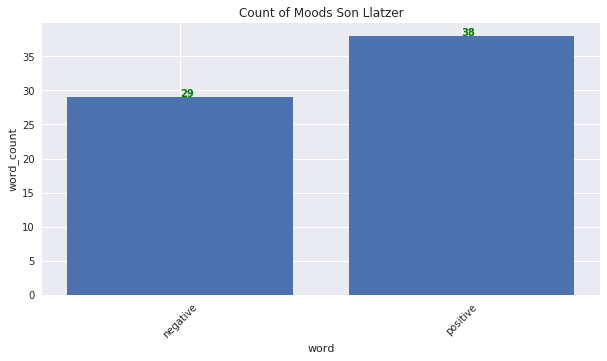

In [590]:
#Hospital Son Llatzer
#Library scikit-learn and NLTK.
#!pip install spanish_sentiment_analysis

#Import module
from classifier import *
clf = SentimentClassifier()
X = dfaux1['free text survey'].values
Sentiment_words=[]
for e in X:
    #print(e + ' ==> %.5f' % clf.predict(e))
    if e <="0.25":
        Sentiment_words.append('negative')
    elif "0.25" > e < "0.5":
        Sentiment_words.append('somewhat negative')
    elif e == 0.5:
        Sentiment_words.append('neutral')
    elif "0.5" > e < "0.75":
        Sentiment_words.append('somewhat positive')
    elif e >="0.75" :
        Sentiment_words.append('positive')
    else:
        Sentiment_words.append('Failed')
        
dfaux1['Sentiment_words'] = Sentiment_words
word_count=pd.value_counts(dfaux1['Sentiment_words'].values, sort=False)
word_count

#Plot
Index = [1,2]
plt.figure(figsize=(10,5))
plt.bar(Index,word_count,color = 'blue')
plt.xticks(Index,['negative','positive'],rotation=45)
plt.ylabel('word_count')
plt.xlabel('word')
plt.title('Count of Moods Son Llatzer')
plt.bar(Index, word_count)
for a,b in zip(Index, word_count):
    plt.text(a, b, str(b) ,color='green', fontweight='bold')


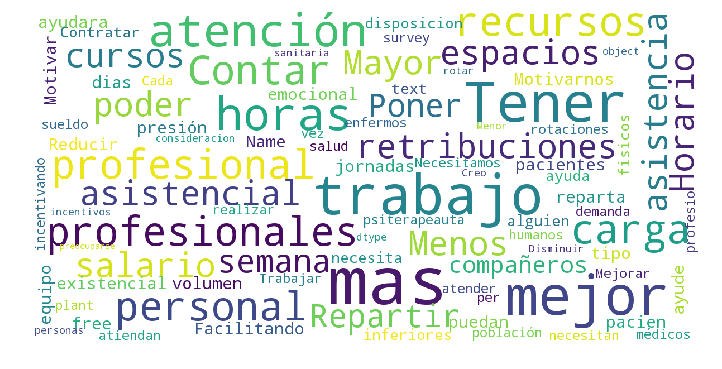

In [591]:
#Positive opinion
positive=dfaux1[dfaux1['Sentiment_words']==('positive')]

#Delete Stop Words and Plot WordCloud
from stop_words import get_stop_words
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
#stop_words = get_stop_words('es')
stopwords = get_stop_words('spanish') #https://pypi.org/project/stop-words/

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(positive['free text survey'])

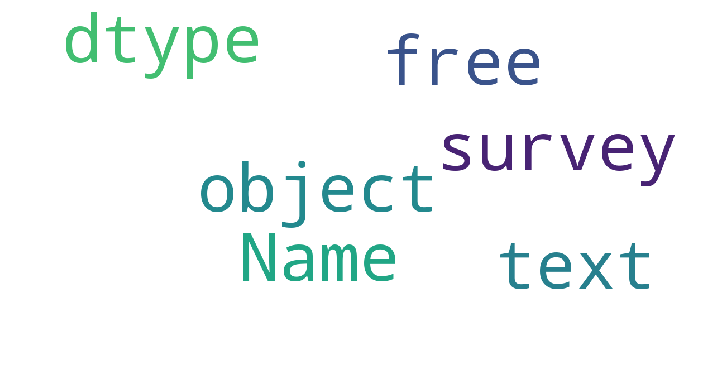

,email,hospital,free text survey,length,burnout,words_comment_token,words_comment,variance_word_counts,Sentiment_words
0,uemusuario2@gmail.com,Son Llatzer,,0,NO,[],0.0,0.0,negative
20,uemusuario1@gmail.com,Son Llatzer,,0,NO,[],0.0,0.0,negative
39,hs57@g.com,Son Llatzer,,0,NO,[],0.0,0.0,negative
41,hs51@g.com,Son Llatzer,,0,NO,[],0.0,0.0,negative
49,hs56@g.com,Son Llatzer,,0,NO,[],0.0,0.0,negative
75,uemusuario2@gmail.com,Son Llatzer,,0,NO,[],0.0,0.0,negative
83,hs57@g.com,Son Llatzer,,0,NO,[],0.0,0.0,negative
85,hs56@g.com,Son Llatzer,,0,NO,[],0.0,0.0,negative
97,uemusuario1@gmail.com,Son Llatzer,,0,NO,[],0.0,0.0,negative
102,hs51@g.com,Son Llatzer,,0,NO,[],0.0,0.0,negative


In [592]:
#Negative opinion
negative=dfaux1[dfaux1['Sentiment_words']==('negative')]

#Delete Stop Words and Plot WordCloud
from stop_words import get_stop_words
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
#stop_words = get_stop_words('es')
stopwords = get_stop_words('spanish') #https://pypi.org/project/stop-words/

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(negative['free text survey'])

negative

In [593]:
#Hospital Infanta Sofia
# Instantiates a client
client = language.LanguageServiceClient()

#Drop Infanta Sofia rows
dfaux2 = dftext.copy()
dfaux2.drop(dfaux2[dfaux2.hospital == 'Son Llatzer'].index, inplace=True)
# The text to analyze
text = dfaux2['free text survey'].str.cat(sep=', ')

document = types.Document(
    content=text,
    type=enums.Document.Type.PLAIN_TEXT)

# Detects the sentiment of the text
sentiment = client.analyze_sentiment(document=document).document_sentiment

print('Text: {}'.format(text))
print('Sentiment: {}, {}'.format(sentiment.score, sentiment.magnitude))

Text: , Cambiar de trabajo, Tendrian que contratar mas personal, , Supervisión de equipos, Menos horario Mas remuneracion Variedad en las., , Valorar el trabajo bien hecho con promociones, , Sentirme tenido mas en cuenta en la toma de decisiones, , Reducir sobrecargas de trabajo (mas medicos ma…, Disminuir el tiempo de trabajo semanal, , Mas personal trabajo en equipo, Facilitar la promoción profesional, Cuidar los espacios de consulta de descanso pa.., , , Grupos de relexión conjunta sobre las dificultades, Disminuir sobrecarga de trabajo en turnos y guardias, Más reconocimiento por parte de la empresa, Nunca lo van a hacer. Es esteril proponer cosas, Mejorar infraestructura de lugar de trabajo y l…, Mejor salario, , Trabajar menos horas favorecería claramente mi rendimiento, , , Fomentar la iniciativa personal, , , Lo mismo que he dejado reflejado previamente, Facilitar la participacion en la toma de decisiones, Alternar de trabajo, , Cuando se toman decisiones tenerme en cuenta, , E

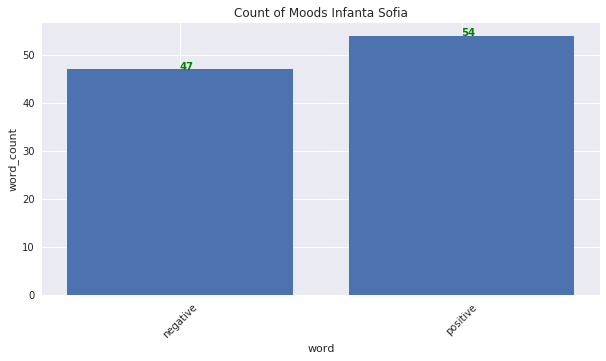

In [594]:
#Hospital Infanta Sofia
#Library scikit-learn and NLTK.
#!pip install spanish_sentiment_analysis

#Import module
from classifier import *
clf = SentimentClassifier()
X = dfaux2['free text survey'].values
Sentiment_words=[]
for e in X:
    #print(e + ' ==> %.5f' % clf.predict(e))
    if e <="0.25":
        Sentiment_words.append('negative')
    elif "0.25" > e < "0.5":
        Sentiment_words.append('somewhat negative')
    elif e == 0.5:
        Sentiment_words.append('neutral')
    elif "0.5" > e < "0.75":
        Sentiment_words.append('somewhat positive')
    elif e >="0.75" :
        Sentiment_words.append('positive')
    else:
        Sentiment_words.append('Failed')
        
dfaux2['Sentiment_words'] = Sentiment_words
word_count=pd.value_counts(dfaux2['Sentiment_words'].values, sort=False)
word_count

#Plot
Index = [1,2]
plt.figure(figsize=(10,5))
plt.bar(Index,word_count,color = 'blue')
plt.xticks(Index,['negative','positive'],rotation=45)
plt.ylabel('word_count')
plt.xlabel('word')
plt.title('Count of Moods Infanta Sofia')
plt.bar(Index, word_count)
for a,b in zip(Index, word_count):
    plt.text(a, b, str(b) ,color='green', fontweight='bold')


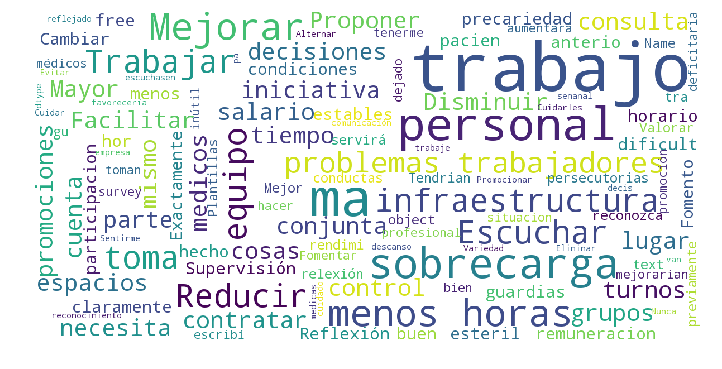

In [595]:
#Positive opinion
positive=dfaux2[dfaux2['Sentiment_words']==('positive')]

#Delete Stop Words and Plot WordCloud
from stop_words import get_stop_words
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
#stop_words = get_stop_words('es')
stopwords = get_stop_words('spanish') #https://pypi.org/project/stop-words/

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(positive['free text survey'])

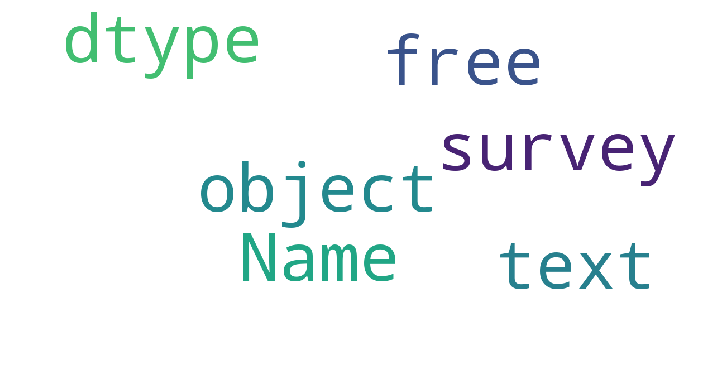

,email,hospital,free text survey,length,burnout,words_comment_token,words_comment,variance_word_counts,Sentiment_words
2,uemusuario11@gmail.com,Infanta Sofia,,0,NO,[],0.0,0.0,negative
5,hs1@g.com,Infanta Sofia,,0,NO,[],0.0,0.0,negative
8,hs3@g.com,Infanta Sofia,,0,NO,[],0.0,0.0,negative
10,uemusuario7@gmail.com,Infanta Sofia,,0,NO,[],0.0,0.0,negative
12,hs11@g.com,Infanta Sofia,,0,NO,[],0.0,0.0,negative
15,hs12@g.com,Infanta Sofia,,0,NO,[],0.0,0.0,negative
19,uemusuario6@gmail.com,Infanta Sofia,,0,NO,[],0.0,0.0,negative
21,uemusuario15@gmail.com,Infanta Sofia,,0,SÍ,[],0.0,0.0,negative
36,uemusuario7@gmail.com,Infanta Sofia,,0,NO,[],0.0,0.0,negative
38,hs12@g.com,Infanta Sofia,,0,NO,[],0.0,0.0,negative


In [596]:
#Negative opinion
negative=dfaux2[dfaux2['Sentiment_words']==('negative')]

#Delete Stop Words and Plot WordCloud
from stop_words import get_stop_words
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
#stop_words = get_stop_words('es')
stopwords = get_stop_words('spanish') #https://pypi.org/project/stop-words/

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(negative['free text survey'])
negative

## Análisis de entidades (Google Cloud Natural Language API)

In [597]:
#Hospital Son Llatzer
# Instantiates a client
client = language.LanguageServiceClient()

# The text to analyze
text = dfaux1['free text survey'].str.cat(sep=', ')
   

#if isinstance(text, six.binary_type):
#    text = text.decode('utf-8')

# Instantiates a plain text document.
document = types.Document(
    content=text,
    type=enums.Document.Type.PLAIN_TEXT)

# Detects entities in the document. You can also analyze HTML with:
#   document.type == enums.Document.Type.HTML
entities = client.analyze_entities(document).entities

# entity types from enums.Entity.Type
entity_type = ('DESCONOCIDO', 'PERSONA', 'LOCALIZACIÓN', 'ORGANIZACIÓN',
                   'EVENTO', 'OBRA DE ARTE', 'BUEN CONSUMIDOR', 'OTROS')

for entity in entities:
    print('=' * 20)
    print(u'{:<16}: {}'.format('name', entity.name))
    print(u'{:<16}: {}'.format('type', entity_type[entity.type]))
    print(u'{:<16}: {}'.format('metadata', entity.metadata))
    print(u'{:<16}: {}'.format('salience', entity.salience))
    print(u'{:<16}: {}'.format('wikipedia_url',
            entity.metadata.get('wikipedia_url', '-')))    

name            : población
type            : PERSONA
metadata        : <google.protobuf.pyext._message.ScalarMapContainer object at 0x7f4bc954f8f0>
salience        : 0.25936126708984375
wikipedia_url   : -
name            : profesional
type            : PERSONA
metadata        : <google.protobuf.pyext._message.ScalarMapContainer object at 0x7f4bc92054e0>
salience        : 0.14753855764865875
wikipedia_url   : -
name            : salario
type            : OTROS
metadata        : <google.protobuf.pyext._message.ScalarMapContainer object at 0x7f4bccfb9cb0>
salience        : 0.0738813579082489
wikipedia_url   : -
name            : cursos
type            : OTROS
metadata        : <google.protobuf.pyext._message.ScalarMapContainer object at 0x7f4bd089f990>
salience        : 0.04517213627696037
wikipedia_url   : -
name            : pacientes
type            : PERSONA
metadata        : <google.protobuf.pyext._message.ScalarMapContainer object at 0x7f4bd089f170>
salience        : 0.04119032621

In [598]:
#Hospital Infanta Sofia
# Instantiates a client
client = language.LanguageServiceClient()

# The text to analyze
text = dfaux2['free text survey'].str.cat(sep=', ')
   

#if isinstance(text, six.binary_type):
#    text = text.decode('utf-8')

# Instantiates a plain text document.
document = types.Document(
    content=text,
    type=enums.Document.Type.PLAIN_TEXT)

# Detects entities in the document. You can also analyze HTML with:
#   document.type == enums.Document.Type.HTML
entities = client.analyze_entities(document).entities

# entity types from enums.Entity.Type
entity_type = ('DESCONOCIDO', 'PERSONA', 'LOCALIZACIÓN', 'ORGANIZACIÓN',
                   'EVENTO', 'OBRA DE ARTE', 'BUEN CONSUMIDOR', 'OTROS')

for entity in entities:
    print('=' * 20)
    print(u'{:<16}: {}'.format('name', entity.name))
    print(u'{:<16}: {}'.format('type', entity_type[entity.type]))
    print(u'{:<16}: {}'.format('metadata', entity.metadata))
    print(u'{:<16}: {}'.format('salience', entity.salience))
    print(u'{:<16}: {}'.format('wikipedia_url',
            entity.metadata.get('wikipedia_url', '-')))    

name            : sobrecarga
type            : OTROS
metadata        : <google.protobuf.pyext._message.ScalarMapContainer object at 0x7f4bc92054e0>
salience        : 0.14430853724479675
wikipedia_url   : -
name            : trabajo
type            : OTROS
metadata        : <google.protobuf.pyext._message.ScalarMapContainer object at 0x7f4bd089f990>
salience        : 0.08446500450372696
wikipedia_url   : -
name            : espacios
type            : LOCALIZACIÓN
metadata        : <google.protobuf.pyext._message.ScalarMapContainer object at 0x7f4bd08968a0>
salience        : 0.05336301773786545
wikipedia_url   : -
name            : consulta
type            : OTROS
metadata        : <google.protobuf.pyext._message.ScalarMapContainer object at 0x7f4bd1913990>
salience        : 0.05336301773786545
wikipedia_url   : -
name            : turnos
type            : OTROS
metadata        : <google.protobuf.pyext._message.ScalarMapContainer object at 0x7f4bd3547c10>
salience        : 0.049109790474

## Análisis de sintaxis (Google Natural Language API)

In [599]:
#Hospital Son Llatzer
client = language.LanguageServiceClient()

# The text to analyze
text = dfaux1['free text survey'].str.cat(sep=', ')

# Instantiates a plain text document.
document = types.Document(
    content=text,
    type=enums.Document.Type.PLAIN_TEXT)

# Detects syntax in the document. You can also analyze HTML with:
#   document.type == enums.Document.Type.HTML
tokens = client.analyze_syntax(document).tokens

# part-of-speech tags from enums.PartOfSpeech.Tag
pos_tag = ('DESCONOCIDO', 'ADJ', 'ADP', 'ADV', 'CONJ', 'DET', 'NOMBRE', 'NUM',
               'PRON', 'PRT', 'PUNCT', 'VERB', 'X', 'AFFIX')

for token in tokens:
    print(u'{}: {}'.format(pos_tag[token.part_of_speech.tag],
                               token.text.content))

PUNCT: ,
ADJ: Mejor
NOMBRE: sueldo
PUNCT: , ,
DET: La
NOMBRE: presión
ADJ: asistencial
CONJ: y
VERB: tener
ADV: más
NOMBRE: recursos
CONJ: y
X: p
NOMBRE: ..
PUNCT: ,
DET: La
NOMBRE: población
PRON: que
VERB: demanda
NOMBRE: atención
ADJ: sanitaria
VERB: ha
VERB: aumentado
PUNCT: ,
VERB: Poder
VERB: rotar
PUNCT: \
ADJ: Menor
NOMBRE: volumen
NOMBRE: asistencia
PUNCT: ,
ADV: Mas
NOMBRE: recursos
ADJ: humanos
PUNCT: \
ADV: Mas
NOMBRE: espacios
ADJ: fisicos
PUNCT: \
NOMBRE: Jornada
ADJ: inferior
PUNCT: ,
VERB: Contratar
DET: Otro
ADJ: profesional
PRON: que
PRON: me
VERB: ayudara
ADP: en
PRON: mi
PUNCT: …
PUNCT: ,
VERB: Repartir
DET: la
NOMBRE: carga
ADJ: asistencial
PUNCT: ,
ADV: Menos
NOMBRE: horas
ADV: mas
NOMBRE: profesionales
PUNCT: ,
ADJ: Mejor
NOMBRE: salario
PUNCT: ,
VERB: Disminuir
DET: las
NOMBRE: horas
ADP: de
NOMBRE: trabajo
ADP: a
DET: la
NOMBRE: semana
CONJ: o
DET: lo
PUNCT: …
PUNCT: , ,
ADJ: Mayor
NOMBRE: atención
ADP: al
NOMBRE: trabajo
ADP: en
NOMBRE: equipo
NOMBRE: espacios

In [600]:
#Hospital Infanta Sofia
client = language.LanguageServiceClient()

# The text to analyze
text = dfaux2['free text survey'].str.cat(sep=', ')

# Instantiates a plain text document.
document = types.Document(
    content=text,
    type=enums.Document.Type.PLAIN_TEXT)

# Detects syntax in the document. You can also analyze HTML with:
#   document.type == enums.Document.Type.HTML
tokens = client.analyze_syntax(document).tokens

# part-of-speech tags from enums.PartOfSpeech.Tag
pos_tag = ('DESCONOCIDO', 'ADJ', 'ADP', 'ADV', 'CONJ', 'DET', 'NOMBRE', 'NUM',
               'PRON', 'PRT', 'PUNCT', 'VERB', 'X', 'AFFIX')

for token in tokens:
    print(u'{}: {}'.format(pos_tag[token.part_of_speech.tag],
                               token.text.content))

PUNCT: ,
VERB: Cambiar
ADP: de
NOMBRE: trabajo
PUNCT: ,
VERB: Tendrian
ADP: que
VERB: contratar
ADV: mas
ADJ: personal
PUNCT: , ,
NOMBRE: Supervisión
ADP: de
NOMBRE: equipos
PUNCT: ,
ADV: Menos
NOMBRE: horario
ADV: Mas
ADJ: remuneracion
NOMBRE: Variedad
ADP: en
NOMBRE: las.
PUNCT: , ,
VERB: Valorar
DET: el
NOMBRE: trabajo
ADV: bien
VERB: hecho
ADP: con
NOMBRE: promociones
PUNCT: , ,
VERB: Sentir
PRON: me
VERB: tenido
ADV: mas
ADP: en
NOMBRE: cuenta
ADP: en
DET: la
NOMBRE: toma
ADP: de
NOMBRE: decisiones
PUNCT: , ,
VERB: Reducir
NOMBRE: sobrecargas
ADP: de
NOMBRE: trabajo
PUNCT: (
ADV: mas
ADJ: medicos
X: ma
PUNCT: …
PUNCT: ,
VERB: Disminuir
DET: el
NOMBRE: tiempo
ADP: de
NOMBRE: trabajo
ADJ: semanal
PUNCT: , ,
ADV: Mas
ADJ: personal
NOMBRE: trabajo
ADP: en
NOMBRE: equipo
PUNCT: ,
VERB: Facilitar
DET: la
NOMBRE: promoción
ADJ: profesional
PUNCT: ,
VERB: Cuidar
DET: los
NOMBRE: espacios
ADP: de
NOMBRE: consulta
ADP: de
NOMBRE: descanso
ADJ: pa
PUNCT: ..
PUNCT: , ,
PUNCT: ,
NOMBRE: Grupos

## Analizar el sentimiento en las Entidades (Google Cloud Natural Language API)

In [601]:
#Hospital Son Llatzer
#Detects entity sentiment in the provided text.
client = language.LanguageServiceClient()

# The text to analyze
text = dfaux1['free text survey'].str.cat(sep=', ')

# Translate text to English #

# Imports the Google Cloud client library
from google.cloud import translate
translate_client = translate.Client()
target='en'


# Text can also be a sequence of strings, in which case this method
# will return a sequence of results for each text.
result = translate_client.translate(
    text, target_language=target)

print(u'Text: {}'.format(result['input']))
print(u'Translation: {}'.format(result['translatedText']))
print(u'Detected source language: {}'.format(
    result['detectedSourceLanguage']))

translatedText=u'Translation: {}'.format(result['translatedText'])

# FIN Translate text to English #

document = types.Document(
        content=translatedText.encode('utf-8'),
        type=enums.Document.Type.PLAIN_TEXT)

# Detect and send native Python encoding to receive correct word offsets.
encoding = enums.EncodingType.UTF32



result = client.analyze_entity_sentiment(document, encoding)

for entity in result.entities:
    print('Mentions: ')
    print(u'Name: "{}"'.format(entity.name))
    for mention in entity.mentions:
        print(u'  Begin Offset : {}'.format(mention.text.begin_offset))
        print(u'  Content : {}'.format(mention.text.content))
        print(u'  Magnitude : {}'.format(mention.sentiment.magnitude))
        print(u'  Sentiment : {}'.format(mention.sentiment.score))
        print(u'  Type : {}'.format(mention.type))
    print(u'Salience: {}'.format(entity.salience))
    print(u'Sentiment: {}\n'.format(entity.sentiment))
       

Text: , Mejor sueldo, , La presión asistencial y tener más recursos y p.., La población que demanda atención sanitaria ha aumentado, Poder rotar \ Menor volumen asistencia, Mas recursos humanos \ Mas espacios fisicos \ Jornada inferior, Contratar Otro profesional que me ayudara en mi…, Repartir la carga asistencial, Menos horas mas profesionales, Mejor salario, Disminuir las horas de trabajo a la semana o lo…, , Mayor atención al trabajo en equipo espacios p…, , Mas personal, Horarios retribuciones incentivos mayor plant…, Motivar con dias de cursos…, , Más compañeros para poder atender a los pacientes…, Necesitamos más personal… para tener más ti…, Cada vez hay mas enfermos, Mas personas y jornadas inferiores, Reducir horas de trabajo a la semana, Se necesitan mas médicos, Mejor horario y retribuciones, Motivarnos con cursos, , Tener más recursos de asistencia, Contar con la ayuda de otro profesional, Que se reparta la carga existencial, Trabajar menos horas y contar con más profesion

In [602]:
#Hospital Infanta Sofía
#Detects entity sentiment in the provided text.
client = language.LanguageServiceClient()

# The text to analyze
text = dfaux2['free text survey'].str.cat(sep=', ')

# Translate text to English #

translate_client = translate.Client()
target='en'


# Text can also be a sequence of strings, in which case this method
# will return a sequence of results for each text.
result = translate_client.translate(
    text, target_language=target)

print(u'Text: {}'.format(result['input']))
print(u'Translation: {}'.format(result['translatedText']))
print(u'Detected source language: {}'.format(
    result['detectedSourceLanguage']))

translatedText=u'Translation: {}'.format(result['translatedText'])

# FIN Translate text to English #

document = types.Document(
        content=translatedText.encode('utf-8'),
        type=enums.Document.Type.PLAIN_TEXT)

# Detect and send native Python encoding to receive correct word offsets.
encoding = enums.EncodingType.UTF32



result = client.analyze_entity_sentiment(document, encoding)

for entity in result.entities:
    print('Mentions: ')
    print(u'Name: "{}"'.format(entity.name))
    for mention in entity.mentions:
        print(u'  Begin Offset : {}'.format(mention.text.begin_offset))
        print(u'  Content : {}'.format(mention.text.content))
        print(u'  Magnitude : {}'.format(mention.sentiment.magnitude))
        print(u'  Sentiment : {}'.format(mention.sentiment.score))
        print(u'  Type : {}'.format(mention.type))
    print(u'Salience: {}'.format(entity.salience))
    print(u'Sentiment: {}\n'.format(entity.sentiment))

Text: , Cambiar de trabajo, Tendrian que contratar mas personal, , Supervisión de equipos, Menos horario Mas remuneracion Variedad en las., , Valorar el trabajo bien hecho con promociones, , Sentirme tenido mas en cuenta en la toma de decisiones, , Reducir sobrecargas de trabajo (mas medicos ma…, Disminuir el tiempo de trabajo semanal, , Mas personal trabajo en equipo, Facilitar la promoción profesional, Cuidar los espacios de consulta de descanso pa.., , , Grupos de relexión conjunta sobre las dificultades, Disminuir sobrecarga de trabajo en turnos y guardias, Más reconocimiento por parte de la empresa, Nunca lo van a hacer. Es esteril proponer cosas, Mejorar infraestructura de lugar de trabajo y l…, Mejor salario, , Trabajar menos horas favorecería claramente mi rendimiento, , , Fomentar la iniciativa personal, , , Lo mismo que he dejado reflejado previamente, Facilitar la participacion en la toma de decisiones, Alternar de trabajo, , Cuando se toman decisiones tenerme en cuenta, , E

## Clasificador de texto (Google Cloud Natural Language API)

In [603]:
#Hospital Son Llatzer
# Imports the Google Cloud client library
from google.cloud import translate

#Classifies content categories of the provided text.
client = language.LanguageServiceClient()

# The text to analyze
text = dfaux1['free text survey'].str.cat(sep=', ')

# Translate text to English #

translate_client = translate.Client()
target='en'


# Text can also be a sequence of strings, in which case this method
# will return a sequence of results for each text.
result = translate_client.translate(
    text, target_language=target)

print(u'Text: {}'.format(result['input']))
print(u'Translation: {}'.format(result['translatedText']))
print(u'Detected source language: {}'.format(
    result['detectedSourceLanguage']))

translatedText=u'Translation: {}'.format(result['translatedText'])

# FIN Translate text to English #
document = types.Document(
    content=translatedText.encode('utf-8'),
    type=enums.Document.Type.PLAIN_TEXT)

categories = client.classify_text(document).categories


for category in categories:
    print(u'=' * 20)
    print(u'{:<16}: {}'.format('name', category.name))
    print(u'{:<16}: {}'.format('confidence', category.confidence))

Text: , Mejor sueldo, , La presión asistencial y tener más recursos y p.., La población que demanda atención sanitaria ha aumentado, Poder rotar \ Menor volumen asistencia, Mas recursos humanos \ Mas espacios fisicos \ Jornada inferior, Contratar Otro profesional que me ayudara en mi…, Repartir la carga asistencial, Menos horas mas profesionales, Mejor salario, Disminuir las horas de trabajo a la semana o lo…, , Mayor atención al trabajo en equipo espacios p…, , Mas personal, Horarios retribuciones incentivos mayor plant…, Motivar con dias de cursos…, , Más compañeros para poder atender a los pacientes…, Necesitamos más personal… para tener más ti…, Cada vez hay mas enfermos, Mas personas y jornadas inferiores, Reducir horas de trabajo a la semana, Se necesitan mas médicos, Mejor horario y retribuciones, Motivarnos con cursos, , Tener más recursos de asistencia, Contar con la ayuda de otro profesional, Que se reparta la carga existencial, Trabajar menos horas y contar con más profesion

In [604]:
#Hospital Infanta Sofia
# Imports the Google Cloud client library
from google.cloud import translate

#Classifies content categories of the provided text.
client = language.LanguageServiceClient()

# The text to analyze
text = dfaux2['free text survey'].str.cat(sep=', ')

# Translate text to English #

translate_client = translate.Client()
target='en'


# Text can also be a sequence of strings, in which case this method
# will return a sequence of results for each text.
result = translate_client.translate(
    text, target_language=target)

print(u'Text: {}'.format(result['input']))
print(u'Translation: {}'.format(result['translatedText']))
print(u'Detected source language: {}'.format(
    result['detectedSourceLanguage']))

translatedText=u'Translation: {}'.format(result['translatedText'])

# FIN Translate text to English #
document = types.Document(
    content=translatedText.encode('utf-8'),
    type=enums.Document.Type.PLAIN_TEXT)

categories = client.classify_text(document).categories

for category in categories:
    print(u'=' * 20)
    print(u'{:<16}: {}'.format('name', category.name))
    print(u'{:<16}: {}'.format('confidence', category.confidence))

Text: , Cambiar de trabajo, Tendrian que contratar mas personal, , Supervisión de equipos, Menos horario Mas remuneracion Variedad en las., , Valorar el trabajo bien hecho con promociones, , Sentirme tenido mas en cuenta en la toma de decisiones, , Reducir sobrecargas de trabajo (mas medicos ma…, Disminuir el tiempo de trabajo semanal, , Mas personal trabajo en equipo, Facilitar la promoción profesional, Cuidar los espacios de consulta de descanso pa.., , , Grupos de relexión conjunta sobre las dificultades, Disminuir sobrecarga de trabajo en turnos y guardias, Más reconocimiento por parte de la empresa, Nunca lo van a hacer. Es esteril proponer cosas, Mejorar infraestructura de lugar de trabajo y l…, Mejor salario, , Trabajar menos horas favorecería claramente mi rendimiento, , , Fomentar la iniciativa personal, , , Lo mismo que he dejado reflejado previamente, Facilitar la participacion en la toma de decisiones, Alternar de trabajo, , Cuando se toman decisiones tenerme en cuenta, , E

## NLP Naive Bayes ML (Predecir si un usuario puede o no tener burnout en base a una opinión) - Categorización de texto

In [605]:
#Partiremos de dftext (Todos los usuarios) y de dftextnopulsera y dftextpulsera (Continuación de punto Análisis y Exploración del Dato)


#Quitamos las Stop Words de español
import re
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')


stop = stopwords.words('spanish')
dftext['free text survey'] = dftext['free text survey'].str.lower().str.split()
dftext['free text survey'] = dftext['free text survey'].apply(lambda x: [item for item in x if item not in stop])

[nltk_data] Downloading package stopwords to /content/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [606]:
dftext.head()

,email,hospital,free text survey,length,burnout,words_comment_token,words_comment,variance_word_counts
0,uemusuario2@gmail.com,Son Llatzer,[],0,NO,[],0.0,0.0
1,uemusuario1@gmail.com,Son Llatzer,"[mejor, sueldo]",12,SÍ,"[Mejor, sueldo]",2.0,0.0
2,uemusuario11@gmail.com,Infanta Sofia,[],0,NO,[],0.0,0.0
3,uemusuario5@gmail.com,Infanta Sofia,"[cambiar, trabajo]",18,NO,"[Cambiar, de, trabajo]",3.0,0.0
4,uemusuario14@gmail.com,Infanta Sofia,"[tendrian, contratar, mas, personal]",35,SÍ,"[Tendrian, que, contratar, mas, personal]",5.0,0.0


In [607]:
#Vectorización
"""Actualmente, tenemos los mensajes como listas de tokens (también conocidos como lemas) y ahora tenemos que convertir cada uno de esos mensajes en un vector con el que los modelos de algoritmo de SciKit Learn puedan funcionar.
Ahora convertiremos cada mensaje, representado como una lista de tokens (lemas) arriba, en un vector que los modelos de aprendizaje automático pueden entender.
Lo haremos en tres pasos usando el modelo de bolsa de palabras:

1)Contar cuántas veces ocurre una palabra en cada mensaje (TF)

2)Pesar los conteos, para que los tokens frecuentes obtengan un menor peso (TF_IDF)

3)Normalizar los vectores a la longitud de la unidad, para abstraer de la longitud del texto original (norma L2) """

from sklearn.feature_extraction.text import CountVectorizer

In [608]:
# 1)Contar cuántas veces ocurre una palabra en cada mensaje (TF)
import string
def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Comprobamos los caracteres en buúsqueda de faltas de ortografía
    nopunc = [char for char in mess if char not in string.punctuation]

    # Juntamos otra vez los caracteres para formar una cadena
    nopunc = ''.join(nopunc)
    
    # Eliminamos las StopWords del idioma Español
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('spanish')]



# Hacemos Fit a los textos
bow_transformer = CountVectorizer(analyzer=text_process).fit(dftext['free text survey'])

# Imprimimos el número total de palabras de vocabulario
print(len(bow_transformer.vocabulary_))

90


In [609]:
#Tomamos como ejemplo un mensaje y obtenemos su nube de palabras
message4 = dftext['free text survey'][4]
print(message4)

['tendrian', 'contratar', 'mas', 'personal']


In [610]:
#Vemos su representación vectorial
bow4 = bow_transformer.transform([message4])
print(bow4)
print(bow4.shape)

  (0, 79)	1
(1, 90)


In [611]:
#Esto significa que hay solamente 1 única palabra diferente en el mensaje 5
print(bow_transformer.get_feature_names()[68])

reducirhorastrabajosemana


In [612]:
messages_bow = bow_transformer.transform(dftext['free text survey'])

In [613]:
print('Shape of Sparse Matrix: ', messages_bow.shape)
print('Amount of Non-Zero occurences: ', messages_bow.nnz)

Shape of Sparse Matrix:  (167, 90)
Amount of Non-Zero occurences:  91


In [614]:
sparsity = (100.0 * messages_bow.nnz / (messages_bow.shape[0] * messages_bow.shape[1]))
print('sparsity: {}'.format(round(sparsity)))

sparsity: 1


In [615]:
# 2)Pesar los conteos, para que los tokens frecuentes obtengan un menor peso (TF_IDF)
"""TF-IDF significa frecuencia de documento inversa de frecuencia de término, y el peso de tf-idf es un peso que a menudo se utiliza en la recuperación de información y minería de texto. Este peso es una medida estadística utilizada para evaluar la importancia de una palabra para un documento en una colección o corpus. La importancia aumenta proporcionalmente al número de veces que aparece una palabra en el documento, pero se compensa con la frecuencia de la palabra en el corpus. Las variaciones del esquema de ponderación de tf-idf a menudo son utilizadas por los motores de búsqueda como una herramienta central para calificar y clasificar la relevancia de un documento dada una consulta del usuario.

Una de las funciones de clasificación más simples se calcula sumando el tf-idf para cada término de consulta; muchas funciones de clasificación más sofisticadas son variantes de este modelo simple.

Típicamente, el peso de tf-idf está compuesto por dos términos: el primero calcula la Frecuencia de Términos normalizada (TF), también conocida como. la cantidad de veces que aparece una palabra en un documento, dividida por el número total de palabras en ese documento; el segundo término es la Frecuencia Inversa del Documento (IDF), calculada como el logaritmo del número de documentos en el corpus dividido por el número de documentos donde aparece el término específico.

TF: Frecuencia de término, que mide la frecuencia con la que un término ocurre en un documento. Como cada documento tiene una longitud diferente, es posible que un término aparezca mucho más en documentos largos que en uno más corto. Por lo tanto, el término frecuencia a menudo se divide por la longitud del documento (también conocido como el número total de términos en el documento) como una forma de normalización:

TF (t) = (Número de veces que aparece el término t en un documento) / (Número total de términos en el documento).

IDF: Frecuencia inversa del documento, que mide qué tan importante es un término. Al computar TF, todos los términos se consideran igualmente importantes. Sin embargo, se sabe que ciertos términos, como "es", "de" y "eso", pueden aparecer muchas veces pero tienen poca importancia. Por lo tanto, debemos sopesar los términos frecuentes mientras escalamos los raros, calculando lo siguiente:

IDF (t) = log_e (Número total de documentos / Número de documentos con el término t en él). """

from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer().fit(messages_bow)
messages_tfidf = tfidf_transformer.transform(messages_bow)
tfidf4 = tfidf_transformer.transform(bow4)
print(tfidf4)

  (0, 79)	1.0


In [616]:
#Ahora transformamos el corpus de nubes de palabras en TD-IDF
messages_tfidf = tfidf_transformer.transform(messages_bow)
print(messages_tfidf.shape)

(167, 90)


In [617]:
# Training a model
from sklearn.naive_bayes import MultinomialNB
burnout_detect_model = MultinomialNB().fit(messages_tfidf,dftext['burnout'])

In [618]:
print('predicted:', burnout_detect_model.predict(tfidf4)[0])
print('expected:', dftext.burnout[4])

predicted: NO
expected: SÍ


In [619]:
#Evaluation model
all_predictions = burnout_detect_model.predict(messages_tfidf)
print(all_predictions)

['NO' 'NO' 'NO' 'NO' 'NO' 'NO' 'NO' 'NO' 'NO' 'NO' 'NO' 'NO' 'NO' 'NO'
 'NO' 'NO' 'NO' 'NO' 'NO' 'NO' 'NO' 'NO' 'NO' 'NO' 'NO' 'NO' 'NO' 'NO'
 'NO' 'NO' 'NO' 'NO' 'NO' 'NO' 'NO' 'NO' 'NO' 'NO' 'NO' 'NO' 'NO' 'NO'
 'NO' 'NO' 'NO' 'NO' 'NO' 'NO' 'NO' 'NO' 'NO' 'NO' 'NO' 'NO' 'NO' 'NO'
 'NO' 'NO' 'NO' 'NO' 'NO' 'NO' 'NO' 'NO' 'NO' 'NO' 'NO' 'NO' 'NO' 'NO'
 'NO' 'NO' 'NO' 'NO' 'NO' 'NO' 'NO' 'NO' 'NO' 'NO' 'NO' 'NO' 'NO' 'NO'
 'NO' 'NO' 'NO' 'NO' 'NO' 'NO' 'NO' 'NO' 'NO' 'NO' 'NO' 'NO' 'NO' 'NO'
 'NO' 'NO' 'NO' 'NO' 'NO' 'NO' 'NO' 'NO' 'NO' 'NO' 'NO' 'NO' 'NO' 'NO'
 'NO' 'NO' 'NO' 'NO' 'SÍ' 'NO' 'NO' 'NO' 'NO' 'NO' 'NO' 'NO' 'NO' 'NO'
 'NO' 'NO' 'SÍ' 'NO' 'NO' 'NO' 'NO' 'NO' 'NO' 'NO' 'NO' 'NO' 'NO' 'NO'
 'NO' 'NO' 'NO' 'NO' 'NO' 'NO' 'NO' 'NO' 'NO' 'NO' 'NO' 'NO' 'NO' 'NO'
 'NO' 'NO' 'NO' 'NO' 'NO' 'NO' 'NO' 'NO' 'NO' 'NO' 'NO' 'NO' 'NO']


In [620]:
from sklearn.metrics import classification_report
print (classification_report(dftext['burnout'], all_predictions))

             precision    recall  f1-score   support

         NO       0.75      1.00      0.85       123
         SÍ       1.00      0.05      0.09        44

avg / total       0.81      0.75      0.65       167



In [621]:
#Train Test Split
from sklearn.model_selection import train_test_split

msg_train, msg_test, label_train, label_test = \
train_test_split(dftext['free text survey'], dftext['burnout'], test_size=0.2)

print(len(msg_train), len(msg_test), len(msg_train) + len(msg_test))

133 34 167


In [622]:
#Esto significa que Train = 101 de 127 mensajes y Test = 26 de 127 mensajes con Train 80% y Test 20%

In [623]:
#Crear una clasificación del texto
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [624]:
pipeline.fit(msg_train,label_train)

Pipeline(memory=None,
     steps=[('bow', CountVectorizer(analyzer=<function text_process at 0x7f4bd10ecf28>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preprocessor=No...f=False, use_idf=True)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [625]:
predictions = pipeline.predict(msg_test)

In [626]:
#Imprimimos el reporte de clasificación de Naive Bayes con NPL
print(classification_report(predictions,label_test))

             precision    recall  f1-score   support

         NO       1.00      0.79      0.89        34
         SÍ       0.00      0.00      0.00         0

avg / total       1.00      0.79      0.89        34



## TensorFlow DL (Predecir si un usuario puede o no tener burnout en base a una opinión) - Categorización de texto

In [627]:
#Partiremos de dftext (Todos los usuarios) y de dftextnopulsera y dftextpulsera (Continuación de punto Análisis y Exploración del Dato)

import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras
layers = keras.layers
models = keras.models


# La versión de TensorFlow utilizada es v1.8.0
print("You have TensorFlow version", tf.__version__)

You have TensorFlow version 1.8.0


In [628]:
dftext.head()

,email,hospital,free text survey,length,burnout,words_comment_token,words_comment,variance_word_counts
0,uemusuario2@gmail.com,Son Llatzer,[],0,NO,[],0.0,0.0
1,uemusuario1@gmail.com,Son Llatzer,"[mejor, sueldo]",12,SÍ,"[Mejor, sueldo]",2.0,0.0
2,uemusuario11@gmail.com,Infanta Sofia,[],0,NO,[],0.0,0.0
3,uemusuario5@gmail.com,Infanta Sofia,"[cambiar, trabajo]",18,NO,"[Cambiar, de, trabajo]",3.0,0.0
4,uemusuario14@gmail.com,Infanta Sofia,"[tendrian, contratar, mas, personal]",35,SÍ,"[Tendrian, que, contratar, mas, personal]",5.0,0.0


In [629]:
dftext['burnout'].value_counts()

NO    123
SÍ     44
Name: burnout, dtype: int64

In [630]:
train_size = int(len(dftext) * .8)
print ("Train size: %d" % train_size)
print ("Test size: %d" % (len(dftext) - train_size))

Train size: 133
Test size: 34


In [631]:
def train_test_split(dftext, train_size):
    train = dftext[:train_size]
    test = dftext[train_size:]
    return train, test

In [632]:
#Preparación del dato
train_cat, test_cat = train_test_split(dftext['burnout'], train_size)
train_text, test_text = train_test_split(dftext['free text survey'], train_size)

In [633]:
max_words = 1000
tokenize = keras.preprocessing.text.Tokenizer(num_words=max_words, 
                                              char_level=False)

In [634]:
tokenize.fit_on_texts(train_text) # fit tokenizer para nuestros datos de entrenamiento (Training)
x_train = tokenize.texts_to_matrix(train_text)
x_test = tokenize.texts_to_matrix(test_text)

In [635]:
# Uso de la utilidad de sklearn para convertir los strings del label strings a índices numéricos
encoder = LabelEncoder()
encoder.fit(train_cat)
y_train = encoder.transform(train_cat)
y_test = encoder.transform(test_cat)

In [636]:
# Conversión de los labeles a representación one-hot encoding
num_classes = np.max(y_train) + 1
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [637]:
# Muestreo de los datos de entrenamiento (Training) y test. Esto nos será útil para hacer Debug en el futuro.
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

x_train shape: (133, 1000)
x_test shape: (34, 1000)
y_train shape: (133, 2)
y_test shape: (34, 2)


In [638]:
# Entrenamiento del modelo (Training)
batch_size = 32
epochs = 2
drop_ratio = 0.5

In [639]:
# Construcción del modelo
model = models.Sequential()
model.add(layers.Dense(512, input_shape=(max_words,)))
model.add(layers.Activation('relu'))
model.add(layers.Dense(num_classes))
model.add(layers.Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [640]:
# model.fit entrenará (Training) el modelo
# El parámetro validation_split le dirá a Keras cuanto % de nuestros datos de entrenamiento deberían ser utilizados en la validación
# La validation decrecerá lentamente cuando se ejecute esto evitando así caer en overfitting
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 119 samples, validate on 14 samples
Epoch 1/2
119/119 [==============================] - 0s 4ms/step - loss: 0.6865 - acc: 0.6639 - val_loss: 0.6789 - val_acc: 0.7143
Epoch 2/2
119/119 [==============================] - 0s 464us/step - loss: 0.6306 - acc: 0.7899 - val_loss: 0.6574 - val_acc: 0.7143


In [641]:
# Evaluación del acierto del modelo entrenado (Training)
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

34/34 [==============================] - 0s 308us/step
Test loss: 0.6440014979418587
Test accuracy: 0.7941176470588235


In [642]:
# Generar predicciones
text_labels = encoder.classes_ 

for i in range(10):
    prediction = model.predict(np.array([x_test[i]]))
    predicted_label = text_labels[np.argmax(prediction)]
    print(test_text.iloc[i][:50], "...")
    print('Actual label:' + test_cat.iloc[i])
    print("Predicted label: " + predicted_label + "\n")  

[] ...
Actual label:NO
Predicted label: NO

['plantillas', 'medicas', 'mas', 'estables', 'pacien…'] ...
Actual label:SÍ
Predicted label: NO

['poner', 'alguien', 'profesional', 'ayude', 'com…'] ...
Actual label:NO
Predicted label: NO

[] ...
Actual label:NO
Predicted label: NO

[] ...
Actual label:NO
Predicted label: NO

[] ...
Actual label:NO
Predicted label: NO

[] ...
Actual label:NO
Predicted label: NO

[] ...
Actual label:SÍ
Predicted label: NO

[] ...
Actual label:NO
Predicted label: NO

['sobrecarga', 'trabajo'] ...
Actual label:NO
Predicted label: NO



In [643]:
#Preparar matriz de confusión
y_softmax = model.predict(x_test)

y_test_1d = []
y_pred_1d = []

for i in range(len(y_test)):
    probs = y_test[i]
    index_arr = np.nonzero(probs)
    one_hot_index = index_arr[0].item(0)
    y_test_1d.append(one_hot_index)

for i in range(0, len(y_softmax)):
    probs = y_softmax[i]
    predicted_index = np.argmax(probs)
    y_pred_1d.append(predicted_index)

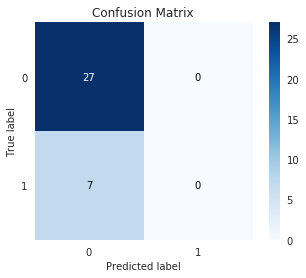

In [644]:
#Imprimir matriz de confusión
import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(y_test_1d, y_pred_1d, normalize=False)
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 30
fig_size[1] = 30
plt.rcParams["figure.figsize"] = fig_size
plt.show()